In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

2024-09-09 18:42:10.061573: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 18:42:10.077506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 18:42:10.096827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 18:42:10.102614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 18:42:10.117171: I tensorflow/core/platform/cpu_feature_guar

In [2]:
!pip install segmentation_models

In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:

weights=[1/6]*6
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [5]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)


In [6]:


new_dict={'[226 169  41]': np.array([1., 0., 0., 0., 0., 0.]),
 '[132  41 246]': np.array([0., 1., 0., 0., 0., 0.]),
 '[110 193 228]': np.array([0., 0., 1., 0., 0., 0.]),
 '[ 60  16 152]': np.array([0., 0., 0., 1., 0., 0.]),
 '[254 221  58]': np.array([0., 0., 0., 0., 1., 0.]),
 '[155 155 155]': np.array([0., 0., 0., 0., 0., 1.])}
def checker_helper(s):
    s = s.strip("[]")
    s_list = s.split()
    int_list = list(map(int, s_list))
    return np.array(int_list)

In [7]:
model=load_model('second_training_model_2.h5',compile=False)
metrics=['accuracy', jacard_coef]
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)



2024-09-09 18:42:15.494088: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-09-09 18:42:15.494117: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: JJJ
2024-09-09 18:42:15.494123: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: JJJ
2024-09-09 18:42:15.494247: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-09-09 18:42:15.494262: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-09-09 18:42:15.494266: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1


# Model Prediction For New Image

In [31]:
cpy_pth='Screenshot from 2024-09-09 18-40-13.png'

In [32]:
path='/home/jackson-divakar/Pictures/Screenshots/'+cpy_pth


In [33]:
image=Image.open(path)
image = image.convert("RGB")

In [34]:
image.size

(1302, 809)

In [35]:

new_dict={'[226 169  41]': np.array([1., 0., 0., 0., 0., 0.]),
 '[132  41 246]': np.array([0., 1., 0., 0., 0., 0.]),
 '[110 193 228]': np.array([0., 0., 1., 0., 0., 0.]),
 '[ 60  16 152]': np.array([0., 0., 0., 1., 0., 0.]),
 '[254 221  58]': np.array([0., 0., 0., 0., 1., 0.]),
 '[155 155 155]': np.array([0., 0., 0., 0., 0., 1.])}
def checker_helper(s):
    s = s.strip("[]")
    s_list = s.split()
    int_list = list(map(int, s_list))
    return np.array(int_list)

In [36]:
def decoder(predicted_mask):
    argmaxed=np.argmax(predicted_mask,axis=-1)
    argmaxed=np.squeeze(argmaxed,axis=0)
    new_dict_2=dict()
    count=0
    for i, j in new_dict.items():
        new_dict_2[count]=checker_helper(i)
        count+=1
    rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
    for key, color in new_dict_2.items():
        rgb_image[argmaxed == key] = color
    return rgb_image

In [37]:
def plot_comparision(image,predicted):
    fig,axes=plt.subplots(1,2,figsize=(10,6))
    axes[0].imshow(image)
    axes[1].imshow(decoder(predicted))
    axes[0].set_axis_off()
    axes[1].set_axis_off()


In [38]:
patch_size=224

In [39]:
SIZE_X = (image.size[0]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (image.size[1]//patch_size)*patch_size

In [40]:
image = image.crop((0 ,0, SIZE_X, SIZE_Y)) 
image = np.array(image)

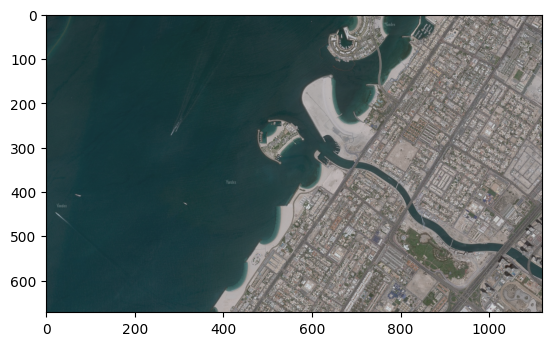

In [41]:
def adjust_contrast(image, factor):
    # Calculate the mean pixel value across all channels
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    
    # Adjust contrast based on the formula
    contrast_image = np.clip(mean + factor * (image - mean), 0, 255).astype(np.uint8)
    
    return contrast_image
factor = 0.75  # Example: Increase contrast by 50%
contrast_image = adjust_contrast(image, factor)
plt.imshow(contrast_image)
image=contrast_image 

In [42]:
!pip install patchify

In [43]:
from patchify import patchify

In [44]:
image.shape

(672, 1120, 3)

In [45]:
print("Now patchifying image")
patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size) 

Now patchifying image


In [46]:
patches_img.shape

(3, 5, 1, 224, 224, 3)

In [47]:
predicted_array = []
patches_img=np.squeeze(patches_img,axis=2)
# Iterate over all patches
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :] / 255.0  # Normalize patch
        predicted = model.predict(np.expand_dims(single_patch_img,axis=0))  # Predict
        predicted_rgb = decoder(predicted)  # Decode the prediction
        predicted_array.append(predicted_rgb)  # Store the decoded RGB prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


In [48]:
predicted_patches = np.array(predicted_array).reshape(patches_img.shape[0], patches_img.shape[1], 224, 224, 3)


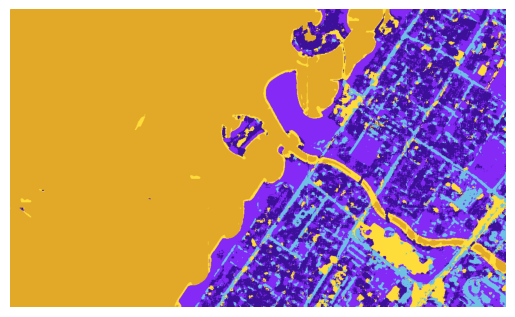

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions
patch_height = 224
patch_width = 224
num_patches_height = patches_img.shape[0]
num_patches_width = patches_img.shape[1]

# Create an empty image of the right size
reconstructed_image = np.zeros((num_patches_height * patch_height, num_patches_width * patch_width, 3), dtype=np.uint8)

# Place patches into the image
for i in range(num_patches_height):
    for j in range(num_patches_width):
        reconstructed_image[i*patch_height:(i+1)*patch_height, j*patch_width:(j+1)*patch_width, :] = predicted_patches[i, j]

# Display the result
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()


In [50]:
reconstructed_image.shape

(672, 1120, 3)

In [51]:
image.shape

(672, 1120, 3)

In [52]:
def plot_comparision(image,predicted):
    fig,axes=plt.subplots(1,2,figsize=(20,20))
    axes[0].imshow(image)
    axes[1].imshow(predicted)
    axes[0].set_axis_off()
    axes[1].set_axis_off()

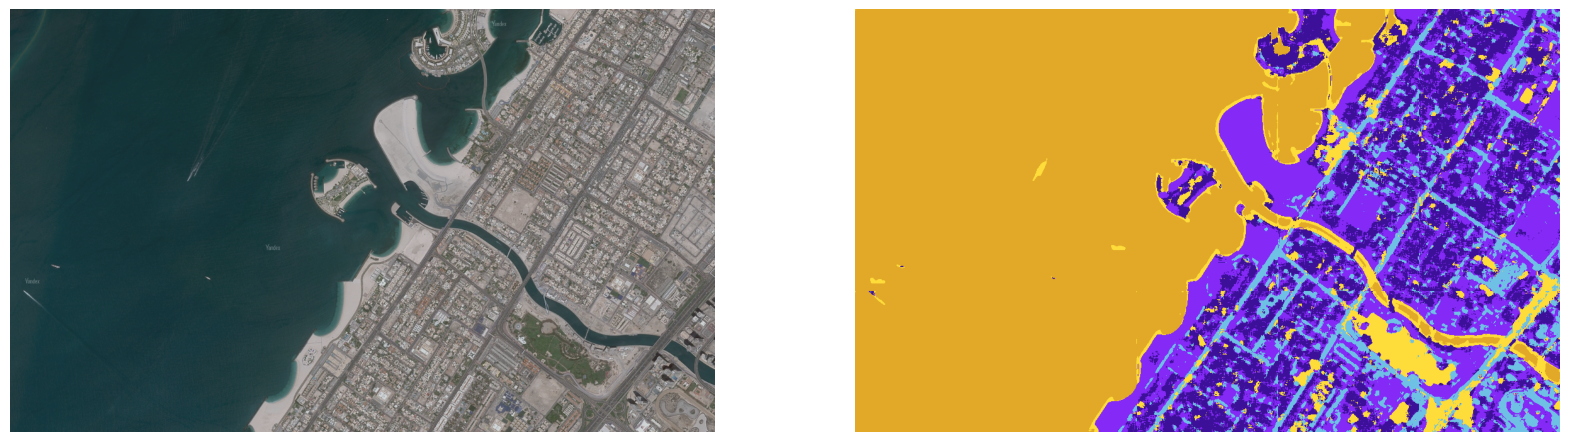

In [53]:
plot_comparision(image,reconstructed_image)